<a href="https://colab.research.google.com/github/Riky2014/NAPDE/blob/main/sfere_sensitivity_kaggle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [ ]:
%%capture
!pip install -U "monai-weekly[fire, nibabel, yaml, tqdm, einops]"

# Import and set directory

In [ ]:
import os
import time
import torch
import tempfile
import numpy as np
import nibabel as nib
from PIL import Image
from glob import glob
import matplotlib.pyplot as plt
from nibabel import load, save, Nifti1Image

import monai
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.utils import set_determinism
from monai.networks.nets import SegResNet
from monai.data import DataLoader, decollate_batch, create_test_image_3d

from monai.transforms import (
    Activations,
    AsDiscrete,
    Compose,
    LoadImaged,
    NormalizeIntensityd,
    Orientationd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    RandSpatialCropd,
    Spacingd,
    EnsureTyped,
    EnsureChannelFirstd,
)

2024-04-06 13:59:53.435077: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 13:59:53.435180: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 13:59:53.590695: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
directory_path = '/kaggle/working/sfere_sensitivity'
os.makedirs(directory_path, exist_ok = True)
os.environ["MONAI_DATA_DIRECTORY"] = directory_path
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

# Function definition

In [ ]:
def create_image_3d(n_train, n_test, noise, r_min, r_max, seed):
  np.random.seed(seed)

  for i in range(n_train + n_test):
    im, seg = create_test_image_3d(128, 128, 128, num_seg_classes = 1, noise_max = noise, rad_min = r_min, rad_max = r_max)
    n = nib.Nifti1Image(im, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"image{i}.nii"))
    n = nib.Nifti1Image(seg, np.eye(4))
    nib.save(n, os.path.join(root_dir, f"label{i}.nii"))

  set_determinism(seed=0)

  images = sorted(glob(os.path.join(root_dir, "image*.nii")))
  labels = sorted(glob(os.path.join(root_dir, "label*.nii")))

  train_files = [{"image": image, "label": label} for image, label in zip(images[:n_train], labels[:n_train])]
  val_files = [{"image": image, "label": label} for image, label in zip(images[-n_test:], labels[-n_test:])]

  return train_files, val_files

In [ ]:
def transform(train_files, val_files):
  train_transform = Compose([
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RAS"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      RandSpatialCropd(keys=["image", "label"], roi_size=[128, 128, 128], random_size=False),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
      RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
      RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
  ])

  val_transform = Compose([
      LoadImaged(keys=["image", "label"]),
      EnsureChannelFirstd(keys=["image","label"]),
      EnsureTyped(keys=["image", "label"]),
      Orientationd(keys=["image", "label"], axcodes="RAS"),
      Spacingd(
          keys=["image", "label"],
          pixdim=(1.0, 1.0, 1.0),
          mode=("bilinear", "nearest"),
      ),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
  ])

  train_ds = monai.data.Dataset(data=train_files, transform=train_transform)
  train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

  val_ds = monai.data.Dataset(data=val_files, transform=val_transform)
  val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=2)

  return train_loader, val_loader, val_ds

In [ ]:
def model_and_train(train_loader, val_loader, max_epochs, val_ds, filters = 16):
  val_interval = 1
  VAL_AMP = True

  device = torch.device("cuda:0")
  model = SegResNet(
    blocks_down=[1, 2, 2, 4], #default: [1, 2, 2, 4]
    blocks_up=[1, 1, 1], #default: [1, 1, 1]
    init_filters=filters,
    in_channels=1,
    out_channels=1,
    dropout_prob=0.2,
  ).to(device)

  loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)
  optimizer = torch.optim.Adam(model.parameters(), 1e-3, weight_decay=1e-6)
  lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

  dice_metric = DiceMetric(include_background=True, reduction="mean")
  dice_metric_train = DiceMetric(include_background=True, reduction="mean")

  post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

  scaler = torch.cuda.amp.GradScaler()
  torch.backends.cudnn.benchmark = True

  epoch_loss_values = []
  metric_values = []
  metric_values_train = []
  total_start = time.time()

  for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = ( batch_data["image"].to(device), batch_data["label"].to(device) )
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)

        outputs = [post_trans(i) for i in decollate_batch(outputs)]

        dice_metric_train(y_pred=outputs, y=labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()

    metric_train = dice_metric_train.aggregate().item()
    metric_values_train.append(metric_train)
    dice_metric_train.reset()

    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"Loss: {epoch_loss:.4f} \nTrain dice: {metric_train:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (val_data["image"].to(device),val_data["label"].to(device))

                val_outputs = model(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]

                dice_metric(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            dice_metric.reset()

            print(f"Test dice: {metric:.4f}")

    print(f"Time: {(time.time() - epoch_start):.4f}")
  total_time = time.time() - total_start
  print(f"Train completed, total time: {total_time}.")
  print()
  print(f"Train metric = {metric_values_train[-1]}, Test metric = {metric_values[-1]}")
  print()
  print()

  model.eval()
  with torch.no_grad():
    i = 0

    val_input = val_ds[i]["image"].unsqueeze(0).to(device)

    val_output = model(val_input)
    val_output = post_trans(val_output[0])

    plt.figure("fig")
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,6))

    ax1.set_title("Image slice")
    ax1.imshow(val_ds[i]["image"][0, :, :, 64].detach().cpu(), cmap="gray")

    ax2.set_title("Label slice")
    ax2.imshow(val_ds[i]["label"][0, :, :, 64].detach().cpu())

    ax3.set_title("Output slice")
    ax3.imshow(val_output[0, :, :, 64].detach().cpu())

    plt.show()

    fig, ax = plt.subplots(1, 2, subplot_kw={"projection": "3d"},figsize = (12,6))

    z, x, y = val_ds[i]["label"][0].astype(np.uint8).nonzero()
    ax[0].scatter(x, y, z)
    ax[0].set_xlim([0,128])
    ax[0].set_ylim([0,128])
    ax[0].set_title("Label")

    z, x, y = val_output[0].astype(np.uint8).nonzero()
    ax[1].scatter(x, y, z)
    ax[1].set_xlim([0,128])
    ax[1].set_ylim([0,128])
    ax[1].set_title("Output")

    plt.show()

  return metric_values_train[-1], metric_values[-1], epoch_loss_values[-1]

In [ ]:
def plot_train_dim(n_train_vec, metric_train, metric_test, loss, r_min, r_max, noise, max_epochs):
  output_dir = '/kaggle/working/output_plots'
  os.makedirs(output_dir, exist_ok=True)
  plot_path = os.path.join(output_dir, f"3D, noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max}).png")

  fig, ax = plt.subplots(1, 2, figsize = (12,6))

  plt.subplot(1,2,1)
  plt.plot(n_train_vec, metric_train, label = 'Train metric', marker='*')
  plt.plot(n_train_vec, metric_test, label = 'Test metric', marker='*')
  plt.xscale('log', base = 10)
  plt.xlabel("Train set dimension")
  plt.title(f"3D, noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(n_train_vec, loss, label = 'Train loss', marker='*', color='red')
  plt.xscale('log', base = 10)
  plt.xlabel("Train set dimension")
  plt.title(f"3D, noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.savefig(plot_path)

In [ ]:
def plot_noise(noise_vec, metric_train, metric_test, loss, r_min, r_max, max_epochs):

  output_dir = '/kaggle/working/output_plots'
  os.makedirs(output_dir, exist_ok=True)
  plot_path = os.path.join(output_dir, f"3D, epochs = {max_epochs}, r = ({r_min}, {r_max}).png")

  fig, ax = plt.subplots(1, 2, figsize = (12,6))

  plt.subplot(1,2,1)
  plt.plot(noise_vec, metric_train, label = 'Train metric', marker='*')
  plt.plot(noise_vec, metric_test, label = 'Test metric', marker='*')
  plt.xlabel("Noise")
  plt.title(f"3D, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(noise_vec, loss, label = 'Train loss', marker='*', color='red')
  plt.xlabel("Noise")
  plt.title(f"3D, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.savefig(plot_path)

In [ ]:
def plot_capacity(capacity_vec, metric_train, metric_test, loss, r_min, r_max, noise, max_epochs):

  output_dir = '/kaggle/working/output_plots'
  os.makedirs(output_dir, exist_ok=True)
  plot_path = os.path.join(output_dir, f"3D, noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max}).png")

  fig, ax = plt.subplots(1, 2, figsize = (12,6))

  plt.subplot(1,2,1)
  plt.plot(capacity_vec, metric_train, label = 'Train metric', marker='*')
  plt.plot(capacity_vec, metric_test, label = 'Test metric', marker='*')
  plt.xscale('log', base = 10)
  plt.xlabel("Capacity")
  plt.title(f"3D, noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.subplot(1,2,2)
  plt.plot(capacity_vec, loss, label = 'Train loss', marker='*', color='red')
  plt.xscale('log', base = 10)
  plt.xlabel("Capacity")
  plt.title(f"3D, noise = {noise}, epochs = {max_epochs}, r = ({r_min}, {r_max})")
  plt.legend()

  plt.savefig(plot_path)

In [ ]:
def delete_image(directory_path):
  file_list = os.listdir(directory_path)
  for file in file_list:
      file_path = os.path.join(directory_path, file)
      if os.path.isfile(file_path):
          os.remove(file_path)
      elif os.path.isdir(file_path):
          os.rmdir(file_path)
  print()

# Execute training
Specify:
- minimum radius ("r_min": int)
- maximum radius ("r_max": int)
- noise to be added ("noise": float)
- training epochs ("max_epochs": int)

## Dimention train samples


Number of training images = 8
Number of testing images = 30

----------
epoch 1/2
Loss: 0.9468 
Train dice: 0.1317
Test dice: 0.1676
Time: 16.4836
----------
epoch 2/2
Loss: 0.9031 
Train dice: 0.2784
Test dice: 0.4253
Time: 10.9182
Train completed, total time: 27.40186882019043.

Train metric = 0.2783627510070801, Test metric = 0.4252595901489258




<Figure size 640x480 with 0 Axes>

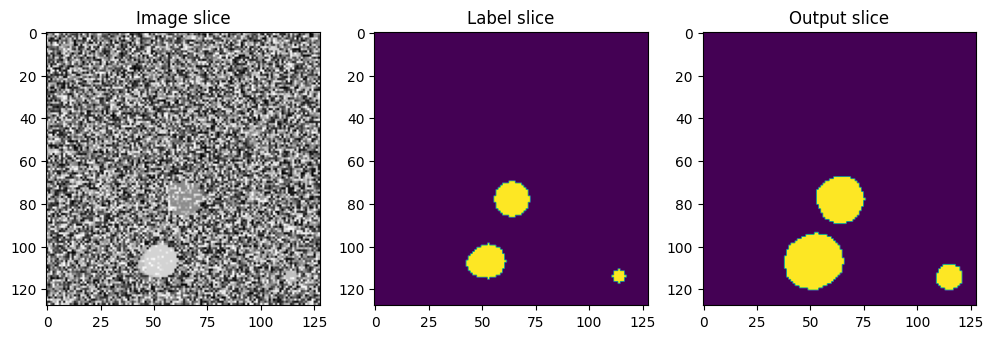

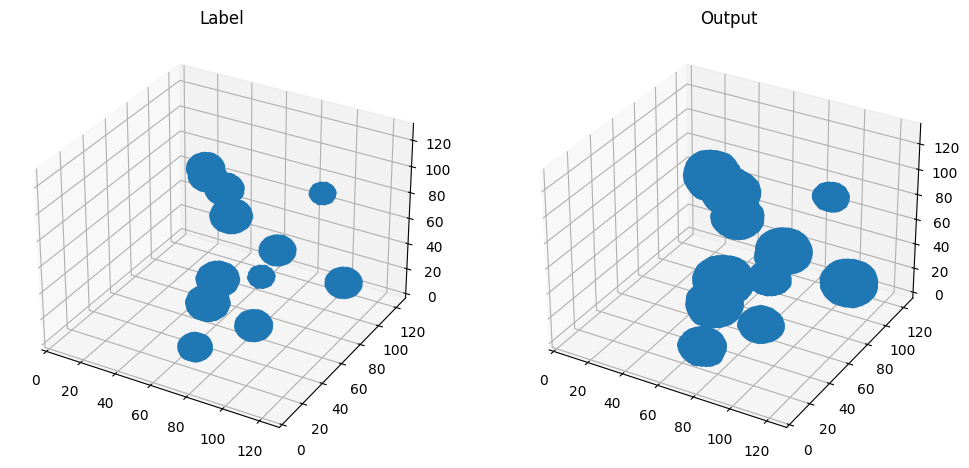



Number of training images = 16
Number of testing images = 30

----------
epoch 1/2
Loss: 0.8969 
Train dice: 0.3720
Test dice: 0.5582
Time: 13.8324
----------
epoch 2/2
Loss: 0.8172 
Train dice: 0.5845
Test dice: 0.6855
Time: 13.7043
Train completed, total time: 27.536725997924805.

Train metric = 0.5845471620559692, Test metric = 0.6855388879776001




<Figure size 640x480 with 0 Axes>

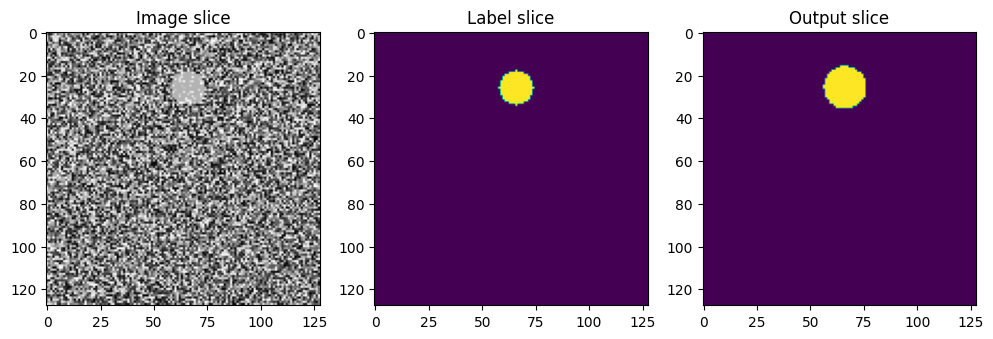

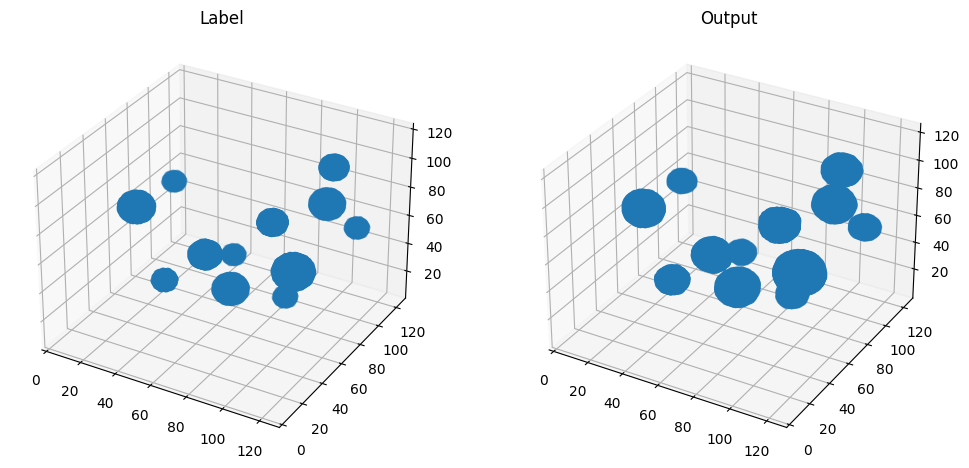



Number of training images = 32
Number of testing images = 30

----------
epoch 1/2
Loss: 0.8902 
Train dice: 0.4337
Test dice: 0.6848
Time: 19.1834
----------
epoch 2/2
Loss: 0.8274 
Train dice: 0.7439
Test dice: 0.7619
Time: 19.1536
Train completed, total time: 38.33696484565735.

Train metric = 0.7438855767250061, Test metric = 0.7619065046310425




<Figure size 640x480 with 0 Axes>

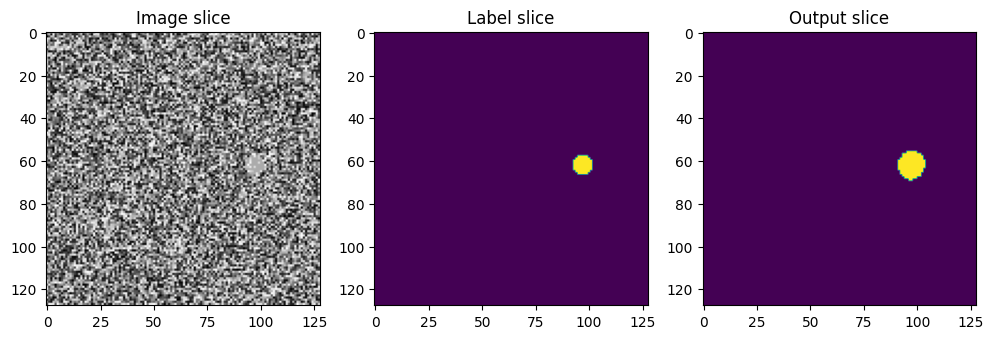

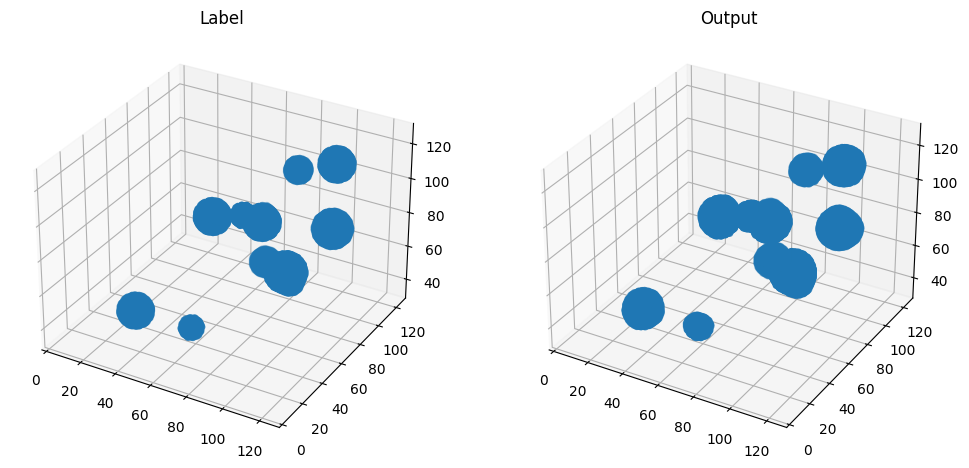



Number of training images = 64
Number of testing images = 30

----------
epoch 1/2
Loss: 0.8349 
Train dice: 0.5977
Test dice: 0.8238
Time: 29.8424
----------
epoch 2/2
Loss: 0.6540 
Train dice: 0.8754
Test dice: 0.9267
Time: 29.9928
Train completed, total time: 59.835230112075806.

Train metric = 0.875359296798706, Test metric = 0.9266570806503296




<Figure size 640x480 with 0 Axes>

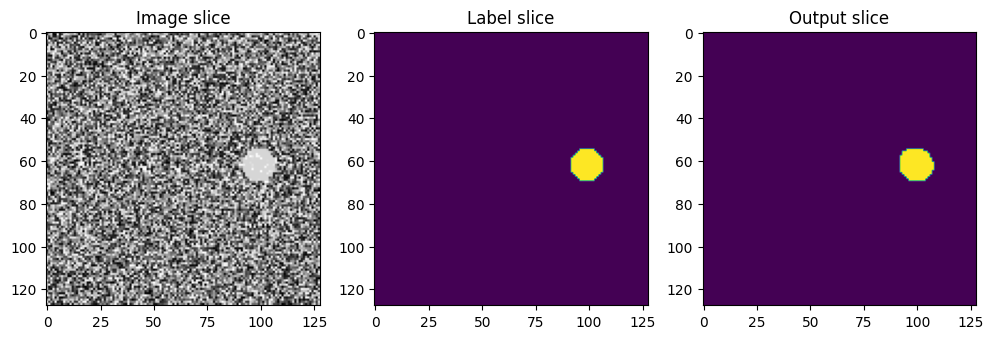

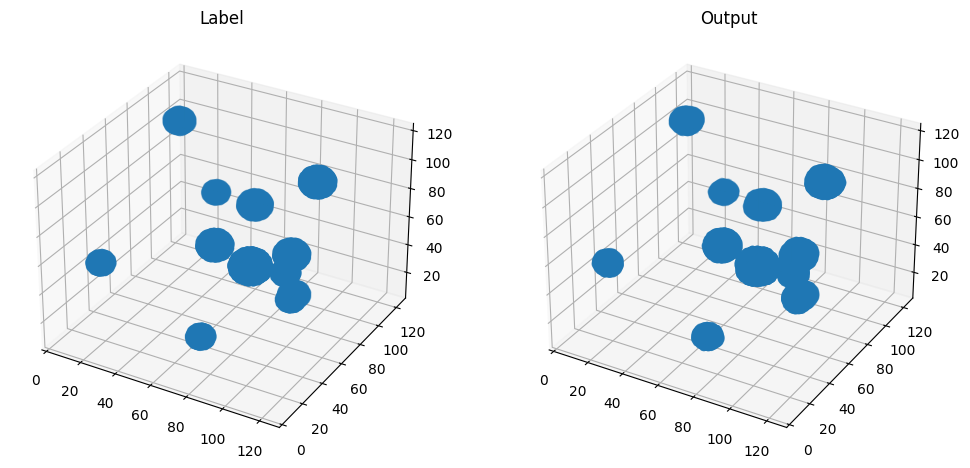



Number of training images = 128
Number of testing images = 30

----------
epoch 1/2
Loss: 0.7218 
Train dice: 0.7477
Test dice: 0.9444
Time: 52.0210
----------
epoch 2/2
Loss: 0.2212 
Train dice: 0.9563
Test dice: 0.9679
Time: 51.4929
Train completed, total time: 103.51388382911682.

Train metric = 0.956261157989502, Test metric = 0.9679020047187805




<Figure size 640x480 with 0 Axes>

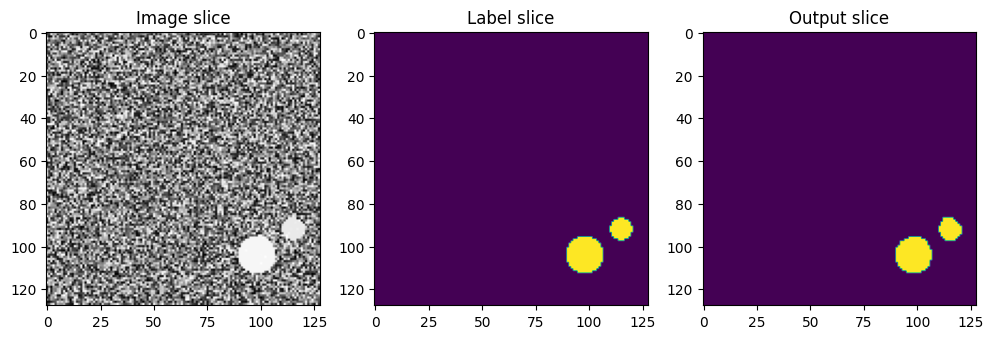

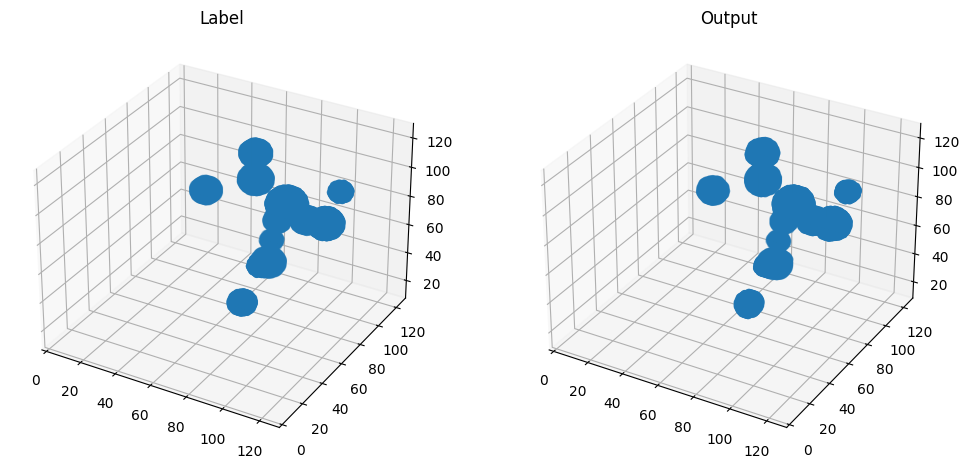

In [ ]:
n_train_vec  = [8, 16, 32, 64, 128]
n_test = 30

noise = 1
r_min = 5
r_max = 10

max_epochs = 2

metric_values_train_vec = []
metric_values_vec = []
epoch_loss_values_vec = []


for n_train in n_train_vec:
  print()
  print(f"Number of training images = {n_train}")
  print(f"Number of testing images = {n_test}")
  print()

  train_files, val_files = create_image_3d(n_train, n_test, noise, r_min, r_max, n_train)
  train_loader, val_loader, val_ds = transform(train_files, val_files)

  metric_value_train, metric_value, epoch_loss_value = model_and_train(train_loader, val_loader, max_epochs, val_ds)

  metric_values_train_vec.append(metric_value_train)
  metric_values_vec.append(metric_value)
  epoch_loss_values_vec.append(epoch_loss_value)

  delete_image(directory_path)

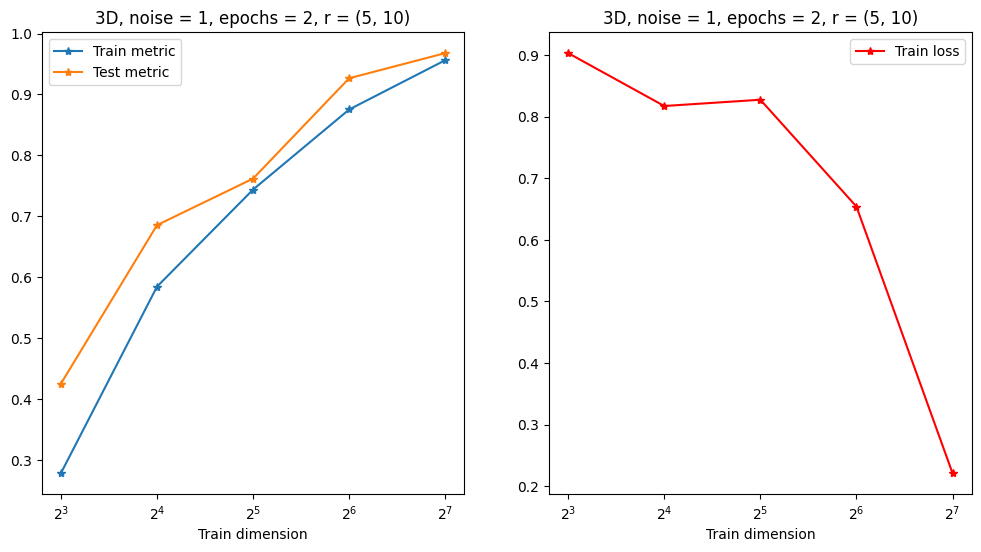

In [ ]:
plot_train_dim(n_train_vec, metric_values_train_vec, metric_values_vec, epoch_loss_values_vec, r_min, r_max, noise, max_epochs)

## Noise


Noise = 0

----------
epoch 1/2
Loss: 0.8302 
Train dice: 0.5690
Test dice: 0.7734
Time: 20.7307
----------
epoch 2/2
Loss: 0.7353 
Train dice: 0.7776
Test dice: 0.8142
Time: 21.1018
Train completed, total time: 41.83243465423584.

Train metric = 0.7775999903678894, Test metric = 0.8141773343086243




<Figure size 640x480 with 0 Axes>

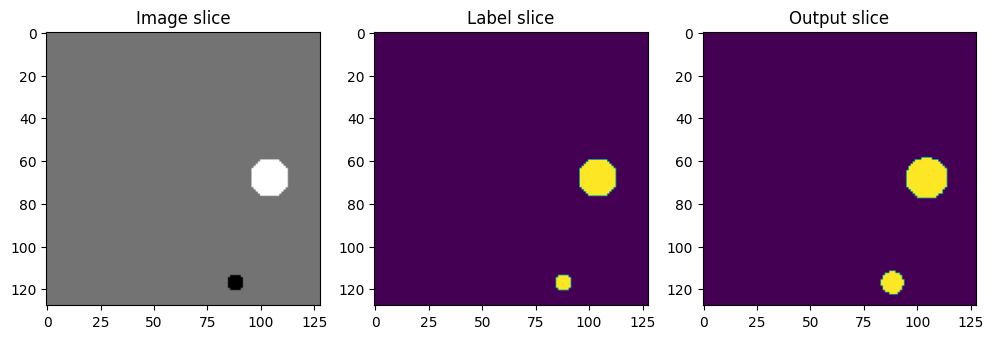

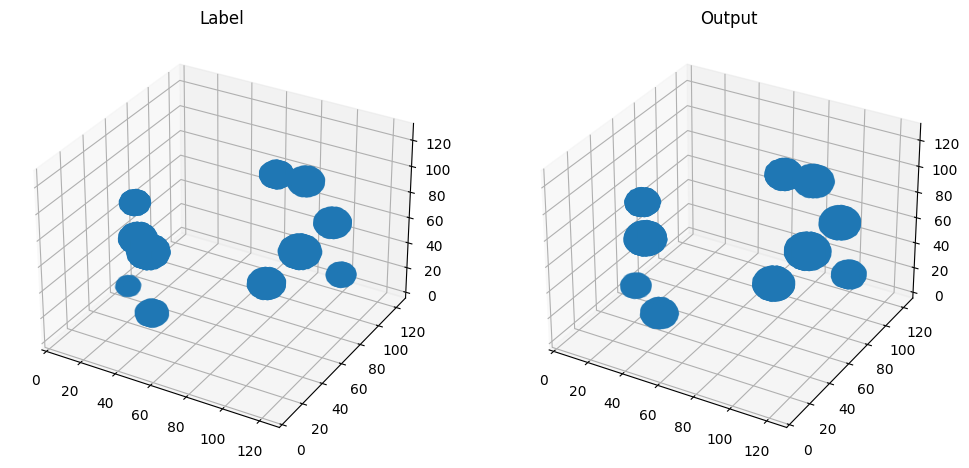



Noise = 0.5

----------
epoch 1/2
Loss: 0.8197 
Train dice: 0.6065
Test dice: 0.8024
Time: 22.1958
----------
epoch 2/2
Loss: 0.7145 
Train dice: 0.8462
Test dice: 0.8380
Time: 22.2967
Train completed, total time: 44.49257206916809.

Train metric = 0.8462196588516235, Test metric = 0.8379507660865784




<Figure size 640x480 with 0 Axes>

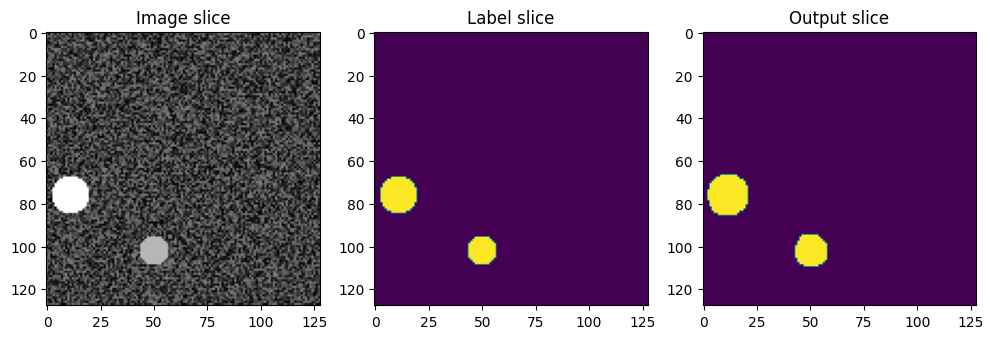

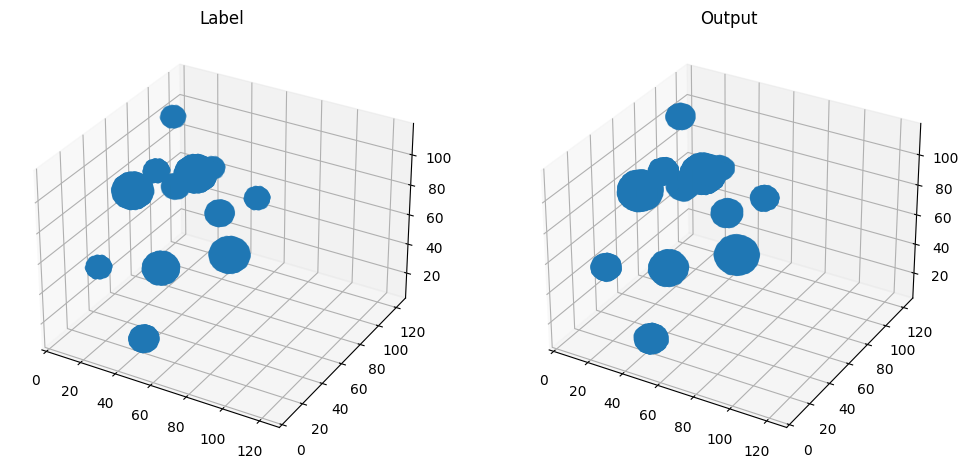



Noise = 1

----------
epoch 1/2
Loss: 0.8355 
Train dice: 0.5360
Test dice: 0.8052
Time: 23.2313
----------
epoch 2/2
Loss: 0.7134 
Train dice: 0.8286
Test dice: 0.8668
Time: 22.3360
Train completed, total time: 45.567343950271606.

Train metric = 0.8285527229309082, Test metric = 0.8668379187583923




<Figure size 640x480 with 0 Axes>

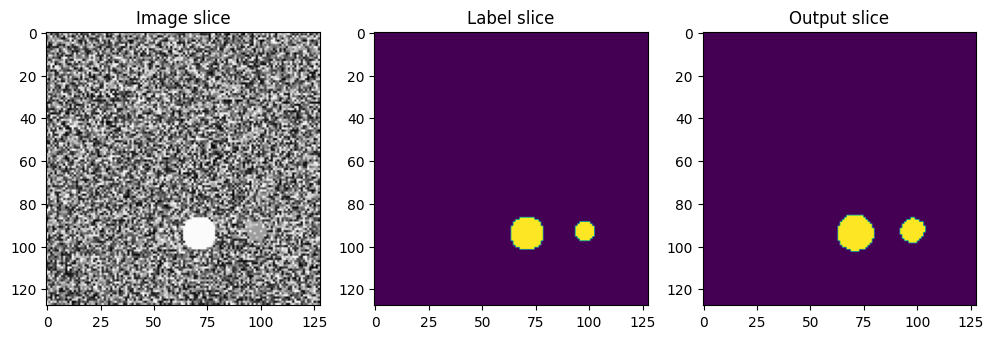

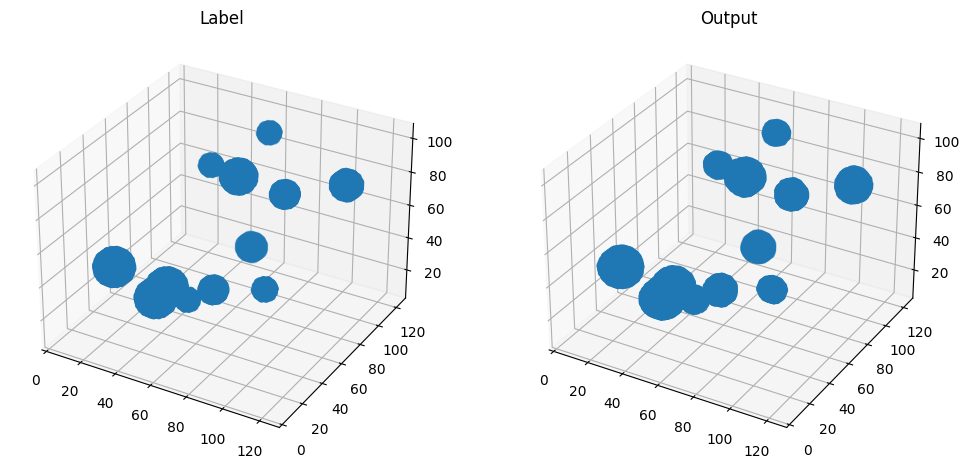



Noise = 2

----------
epoch 1/2
Loss: 0.8332 
Train dice: 0.4954
Test dice: 0.7276
Time: 22.4740
----------
epoch 2/2
Loss: 0.7038 
Train dice: 0.7912
Test dice: 0.7963
Time: 22.0250
Train completed, total time: 44.49904489517212.

Train metric = 0.7912022471427917, Test metric = 0.7963477969169617




<Figure size 640x480 with 0 Axes>

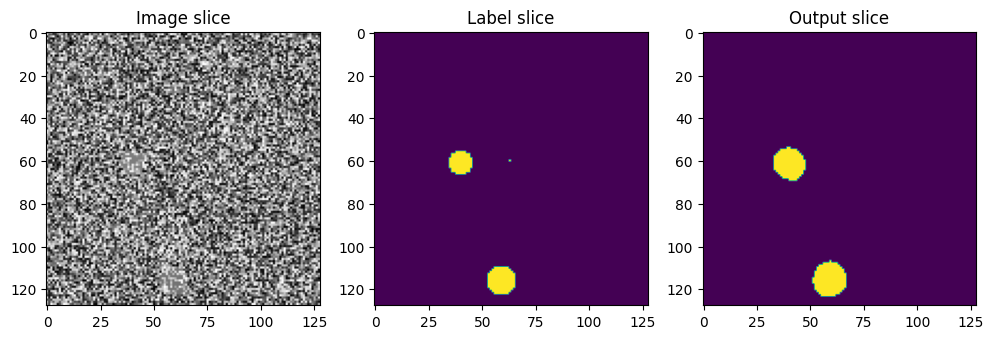

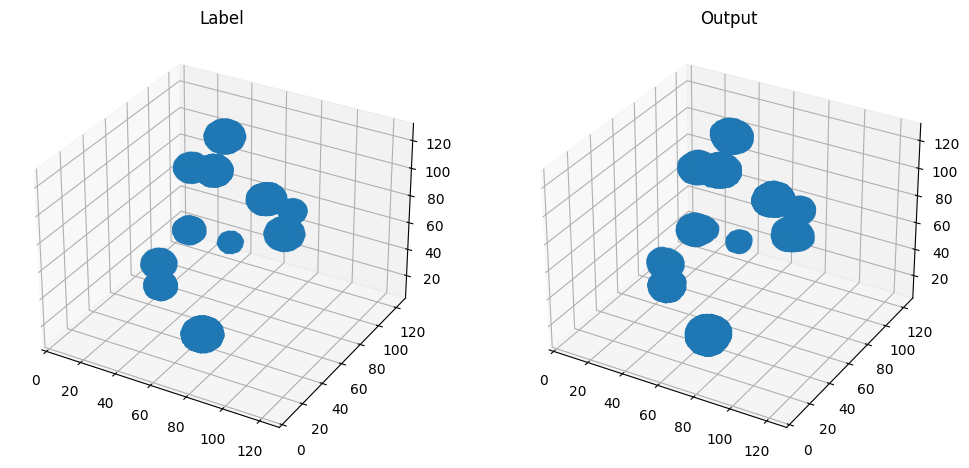



Noise = 3

----------
epoch 1/2
Loss: 0.8588 
Train dice: 0.3874
Test dice: 0.6416
Time: 22.1014
----------
epoch 2/2
Loss: 0.7329 
Train dice: 0.7073
Test dice: 0.7369
Time: 22.4588
Train completed, total time: 44.560258865356445.

Train metric = 0.7073214650154114, Test metric = 0.7369254231452942




<Figure size 640x480 with 0 Axes>

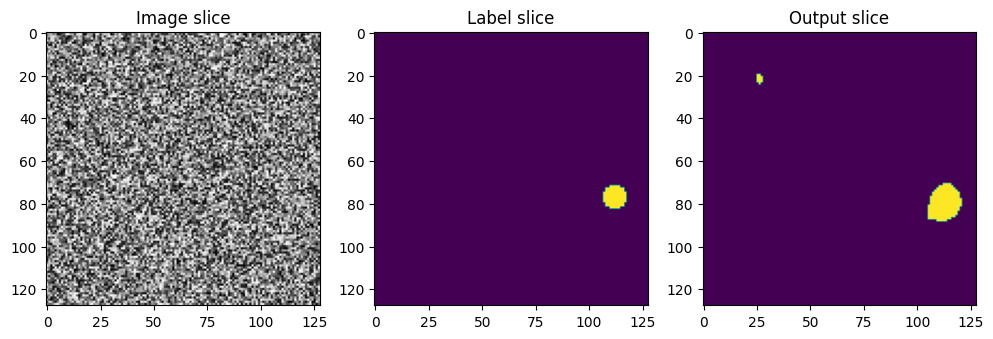

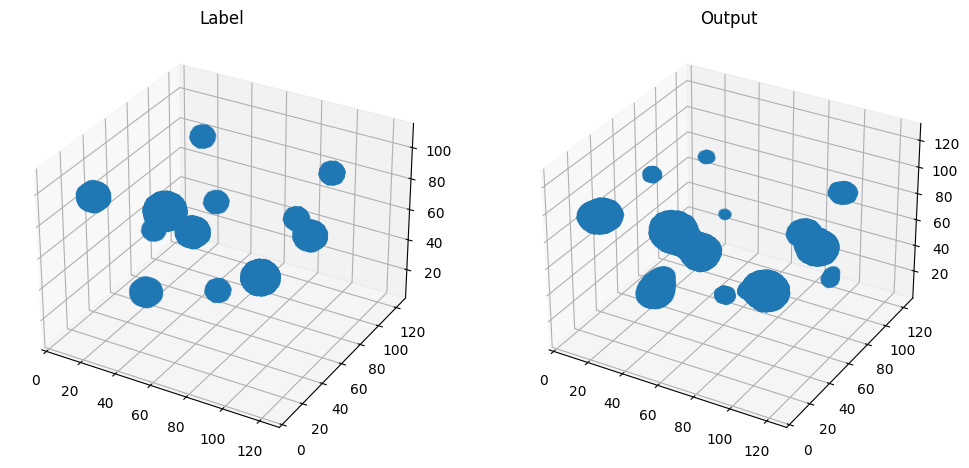



Noise = 4

----------
epoch 1/2
Loss: 0.8805 
Train dice: 0.2908
Test dice: 0.5756
Time: 22.1793
----------
epoch 2/2
Loss: 0.7604 
Train dice: 0.5842
Test dice: 0.6918
Time: 22.1461
Train completed, total time: 44.32546949386597.

Train metric = 0.5842310190200806, Test metric = 0.6918027997016907




<Figure size 640x480 with 0 Axes>

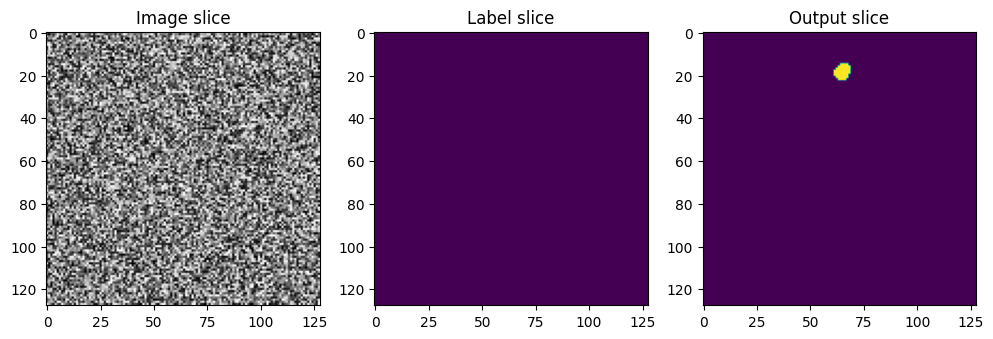

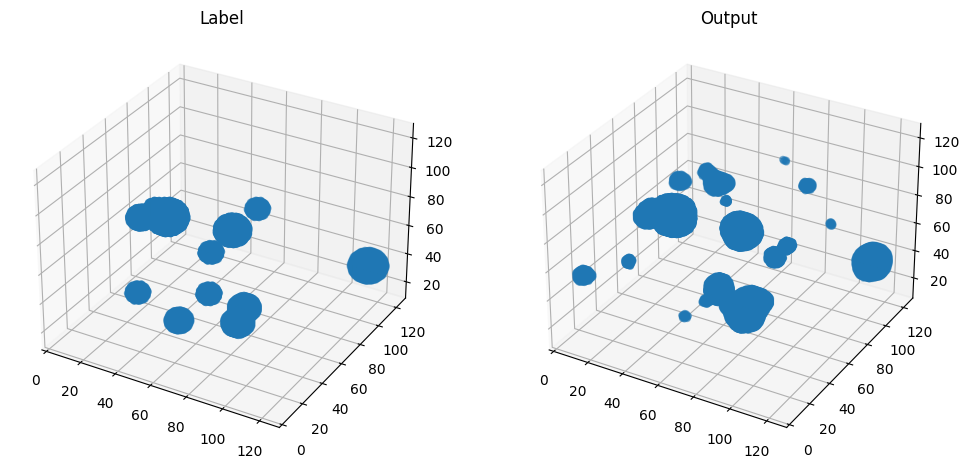



Noise = 5

----------
epoch 1/2
Loss: 0.9058 
Train dice: 0.1790
Test dice: 0.3915
Time: 22.2091
----------
epoch 2/2
Loss: 0.7979 
Train dice: 0.4279
Test dice: 0.4856
Time: 22.2492
Train completed, total time: 44.458298444747925.

Train metric = 0.42785921692848206, Test metric = 0.4855784773826599




<Figure size 640x480 with 0 Axes>

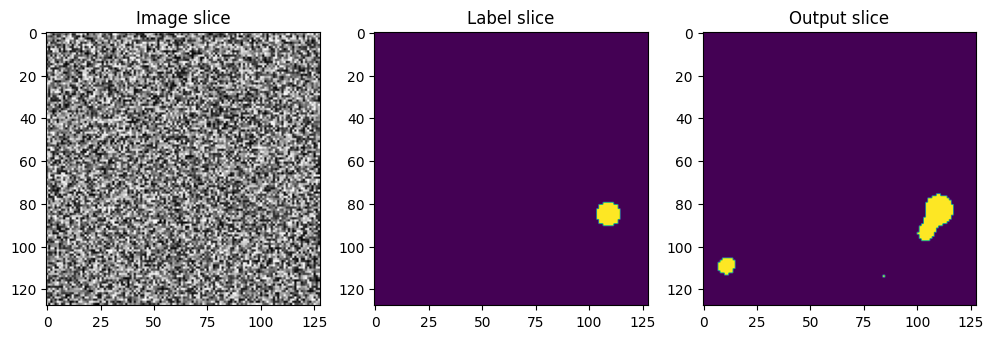

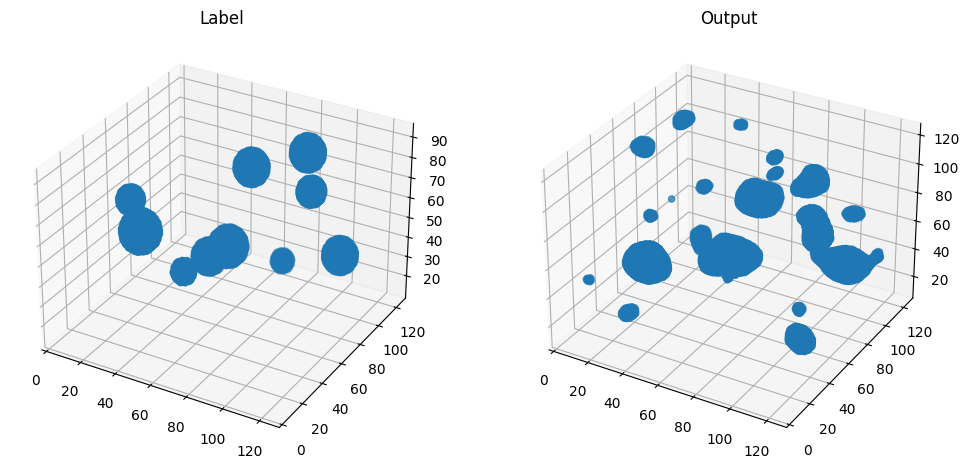



Noise = 6

----------
epoch 1/2
Loss: 0.9231 
Train dice: 0.1098
Test dice: 0.2318
Time: 22.3824
----------
epoch 2/2
Loss: 0.8340 
Train dice: 0.3177
Test dice: 0.3624
Time: 22.5486
Train completed, total time: 44.931067943573.

Train metric = 0.31773823499679565, Test metric = 0.36238372325897217




<Figure size 640x480 with 0 Axes>

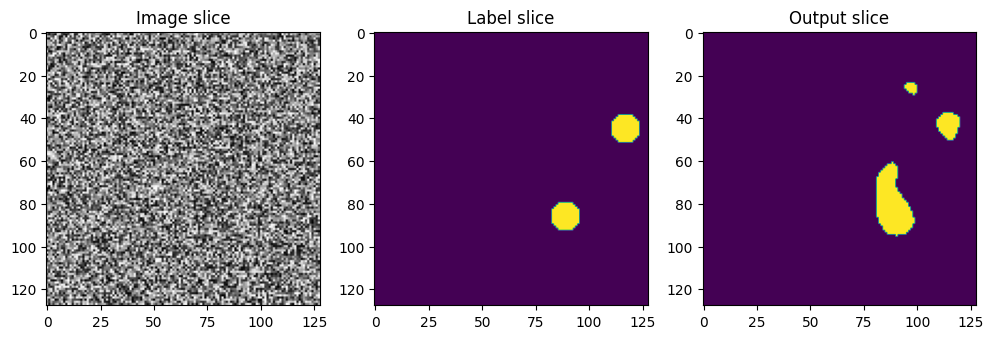

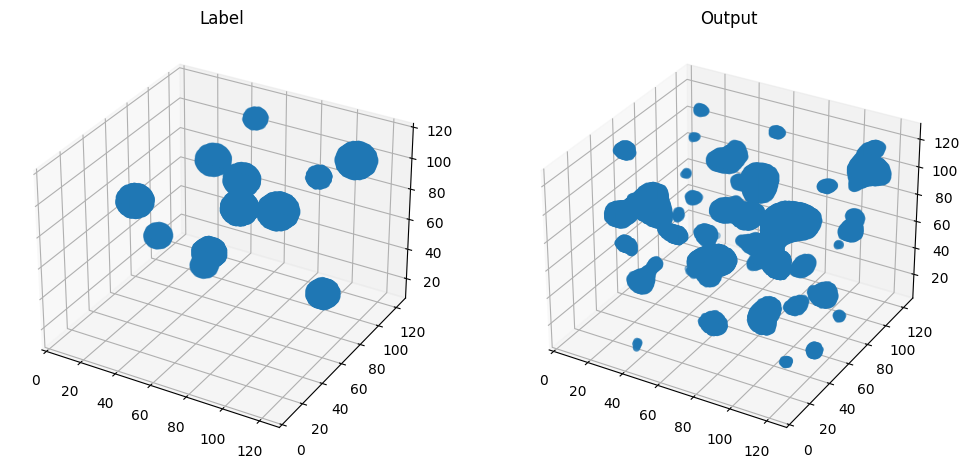



Noise = 7

----------
epoch 1/2
Loss: 0.9313 
Train dice: 0.0818
Test dice: 0.1923
Time: 22.3250
----------
epoch 2/2
Loss: 0.8674 
Train dice: 0.2257
Test dice: 0.2585
Time: 22.3227
Train completed, total time: 44.6478054523468.

Train metric = 0.22570493817329407, Test metric = 0.258453905582428




<Figure size 640x480 with 0 Axes>

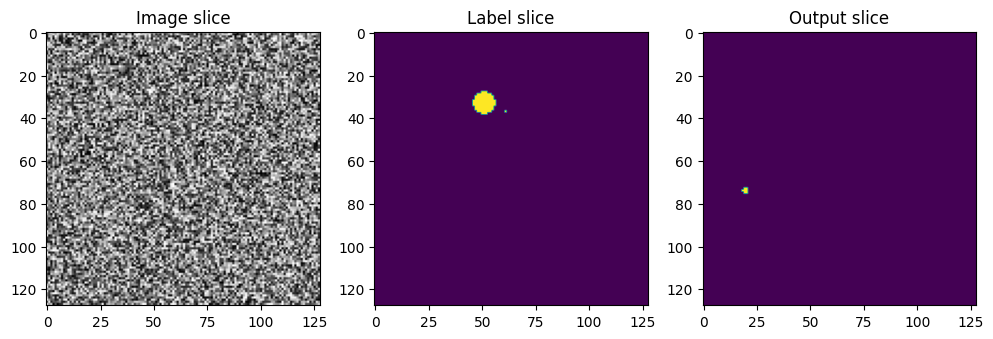

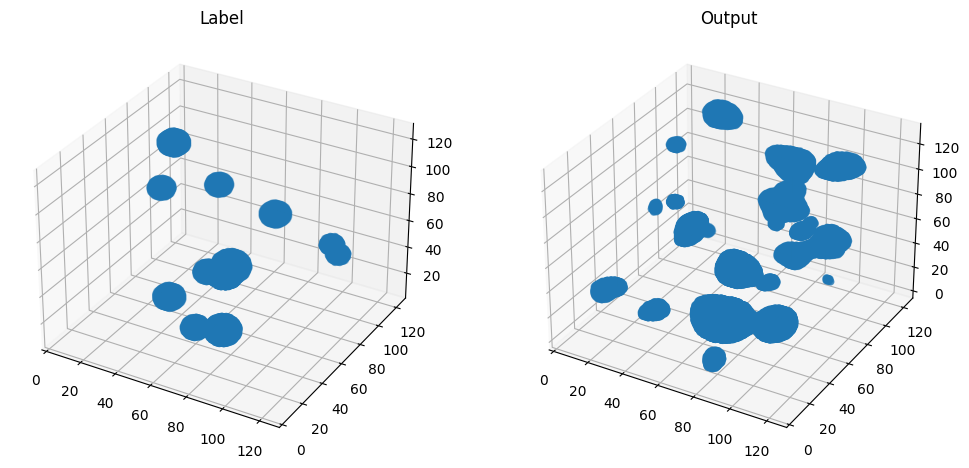

In [ ]:
n_train = 40
n_test = 30

noise_vec = [0, 0.5, 1, 2, 3, 4, 5, 6, 7]
r_min = 5
r_max = 10

max_epochs = 2

metric_values_train_vec = []
metric_values_vec = []
epoch_loss_values_vec = []

for noise in noise_vec:
  print()
  print(f"Noise = {noise}")
  print()

  train_files, val_files = create_image_3d(n_train, n_test, noise, r_min, r_max, int(10 * noise))
  train_loader, val_loader, val_ds = transform(train_files, val_files)

  metric_value_train, metric_value, epoch_loss_value = model_and_train(train_loader, val_loader, max_epochs, val_ds)

  metric_values_train_vec.append(metric_value_train)
  metric_values_vec.append(metric_value)
  epoch_loss_values_vec.append(epoch_loss_value)

  delete_image(directory_path)

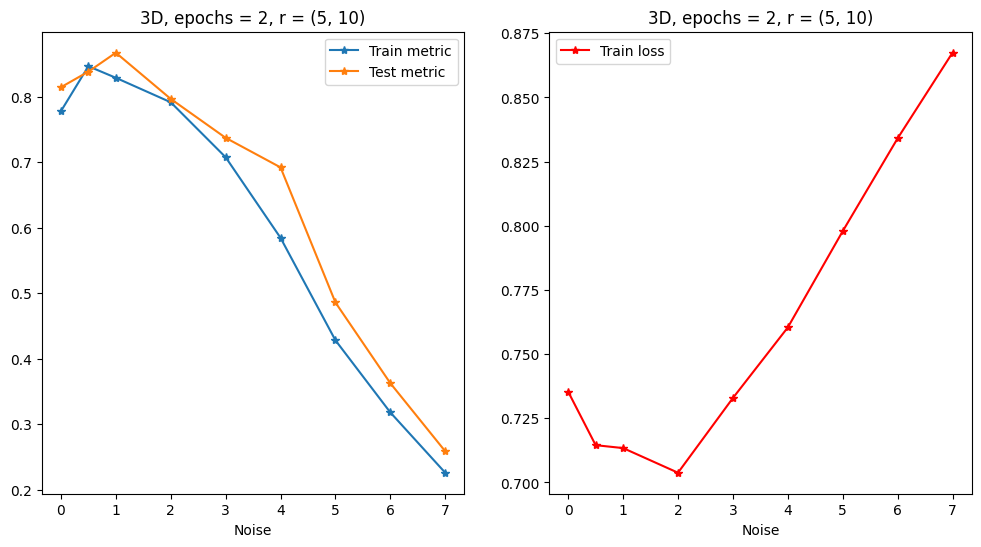

In [ ]:
plot_noise(noise_vec, metric_values_train_vec, metric_values_vec, epoch_loss_values_vec, r_min, r_max, max_epochs)

## Capacity

In [ ]:
n_train = 40
n_test = 20

noise = 1.0
r_min = 5
r_max = 10

max_epochs = 20

capacity_vec = [8, 16, 32, 64]

metric_values_train_vec = []
metric_values_vec = []
epoch_loss_values_vec = []


for init_filters in capacity_vec:
  print()
  print(f"Initial filters = {init_filters}")
  print()

  train_files, val_files = create_image_3d(n_train, n_test, noise, r_min, r_max, init_filters)
  train_loader, val_loader, val_ds = transform(train_files, val_files)

  metric_value_train, metric_value, epoch_loss_value = model_and_train(train_loader,
                                                                       val_loader,
                                                                       max_epochs,
                                                                       val_ds,
                                                                       init_filters)

  metric_values_train_vec.append(metric_value_train)
  metric_values_vec.append(metric_value)
  epoch_loss_values_vec.append(epoch_loss_value)

  delete_image(directory_path)


Initial filters = 64

----------
epoch 1/20


OutOfMemoryError: CUDA out of memory. Tried to allocate 512.00 MiB. GPU 0 has a total capacty of 14.75 GiB of which 243.06 MiB is free. Process 2298 has 14.51 GiB memory in use. Of the allocated memory 13.42 GiB is allocated by PyTorch, and 967.84 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

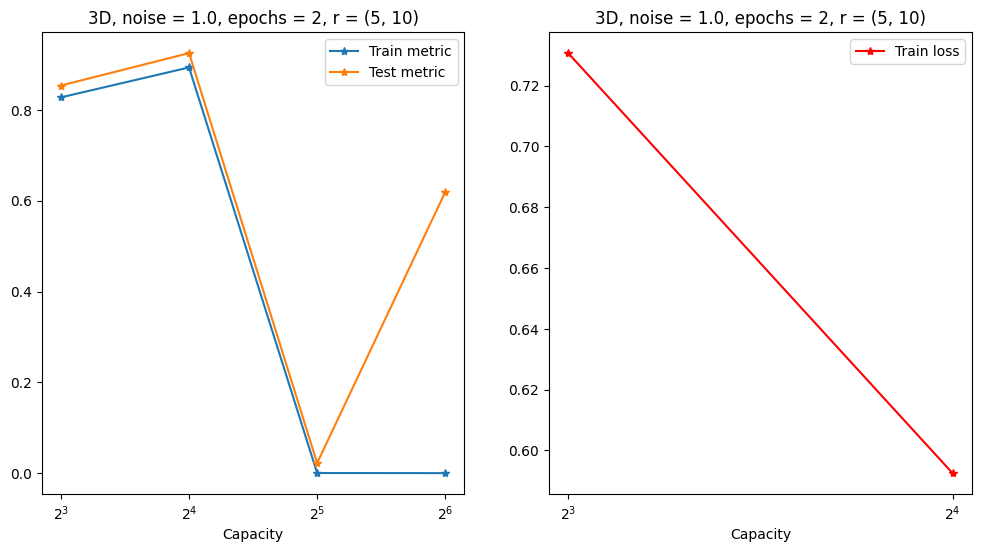

In [ ]:
plot_capacity(capacity_vec,
               metric_values_train_vec,
               metric_values_vec,
               epoch_loss_values_vec,
               r_min,
               r_max,
               noise,
               max_epochs)